In [1]:
from sys import path
path.append('..')
from clearsky.main import IterativeClearSky
from clearsky.utilities import make_time_series, lowpass_2d, fix_time_shifts
import s3fs
import pandas as pd
import numpy as np
from numpy.fft import fft2, fftshift
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
PLOT_ARGS = {
    'linewidth': 1,
    'figsize': (12,8)
}
TZ_LOOKUP = {
    'America/Anchorage': 9,
    'America/Chicago': 6,
    'America/Denver': 7,
    'America/Los_Angeles': 8,
    'America/New_York': 5,
    'America/Phoenix': 7,
    'Pacific/Honolulu': 10
}
from datetime import datetime

In [2]:
def load_sys(n, local=True):
    if local:
        base = '../data/PVO/'
    if not local:
        base = 's3://pvinsight.nrel/PVO/'
    meta = pd.read_csv('../data/PVO/sys_meta.csv')
    id = meta['ID'][n]
    df = pd.read_csv(base+'PVOutput/{}.csv'.format(id), index_col=0,
                      parse_dates=[0], usecols=[1, 3])
    tz = meta['TimeZone'][n]
    df.index = df.index.tz_localize(tz).tz_convert('Etc/GMT+{}'.format(TZ_LOOKUP[tz]))   # fix daylight savings
    start = df.index[0]
    end = df.index[-1]
    time_index = pd.date_range(start=start, end=end, freq='5min')
    df = df.reindex(index=time_index, fill_value=0)
    print(n, id)
    return df

In [3]:
df = load_sys(400, local=False)

400 36066


In [4]:
days = df.resample('D').max().index[1:-1]
start = days[0]
end = days[-1]
print(start.date(), end.date())

2015-06-03 2017-07-30


In [5]:
end - start

Timedelta('788 days 00:00:00')

In [6]:
D = df.loc[start:end].iloc[:-1].values.reshape(288, -1, order='F')
p = df.loc[start:end]

In [7]:
ics = IterativeClearSky(D, k=4)

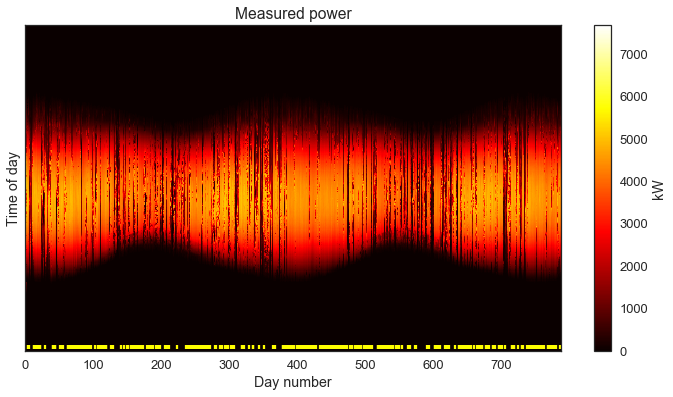

In [8]:
_ = ics.plot_D(show_days=True)

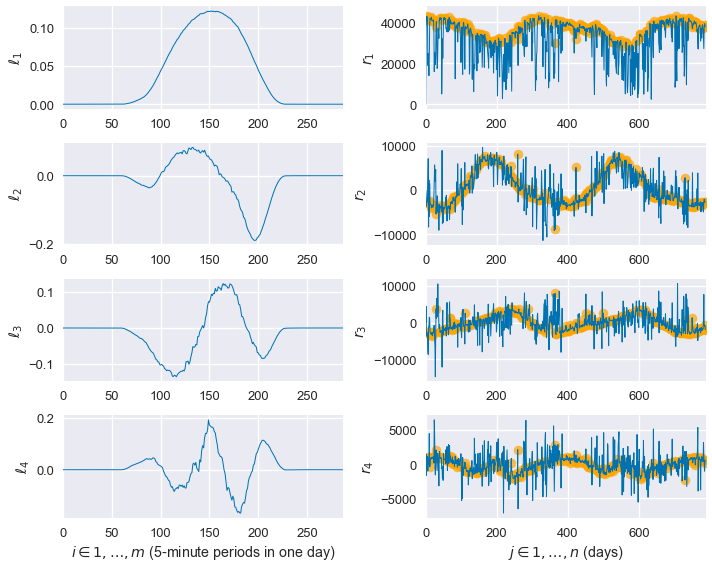

In [9]:
_ = ics.plot_singular_vectors(show_days=True)

In [10]:
ics.mu_L = 1e5
ics.mu_R = 1e3
ics.tau = 0.9
import cvxpy as cvx
try:
    ics.minimize_objective(eps=5e-3, max_iter=10, min_deg=None, max_deg=None)
except cvx.SolverError:
    print('solver failed!')

starting at 552667306.967 [2701846.2069896935, 22335.986308943797, 442170958.07749176, 107772166.69623727]
iteration 1: 1412642.565 [1.29736310e+06 2.00894200e+03 1.13270511e+05 1.10000000e-02]
iteration 2: 1253340.475 [1.14123709e+06 5.73486400e+03 1.06368490e+05 2.90000000e-02]
iteration 3: 1230581.534 [1.11866211e+06 6.98140100e+03 1.04937999e+05 1.90000000e-02]
iteration 4: 1224639.647 [1.11320680e+06 7.07674700e+03 1.04356025e+05 7.70000000e-02]
Minimization complete in 1.01 minutes


In [11]:
clearsky = ics.L_cs.value.dot(ics.R_cs.value)
m = clearsky != 0
residuals = np.divide(clearsky[m] - ics.D[m], clearsky[m])
print(np.linalg.norm(residuals))

74025.57790573758


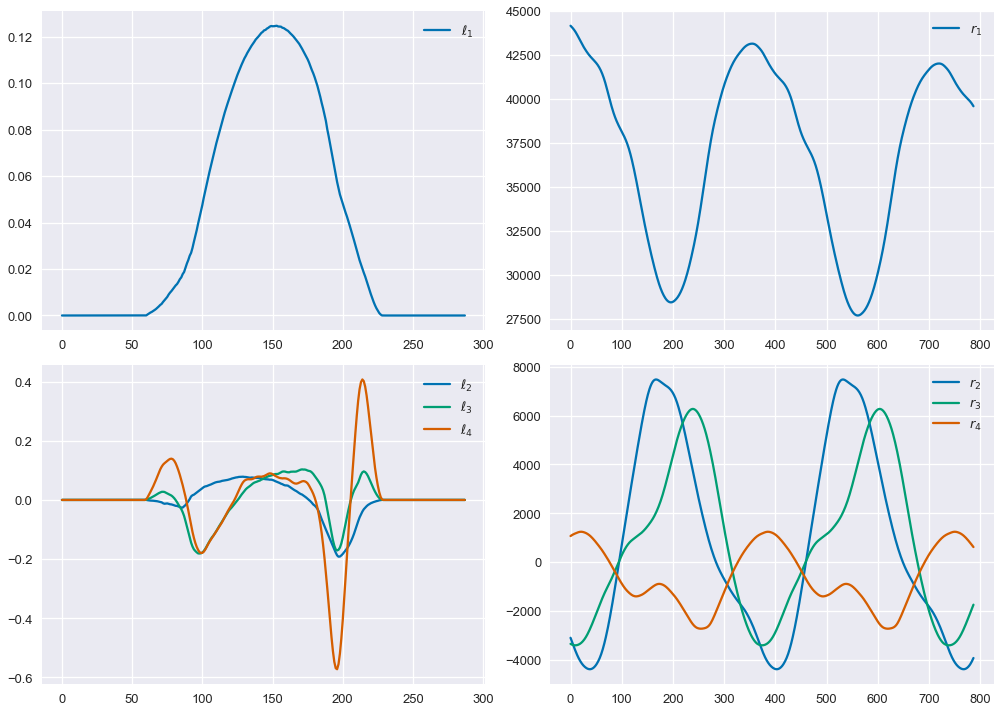

In [12]:
_ = ics.plot_LR()

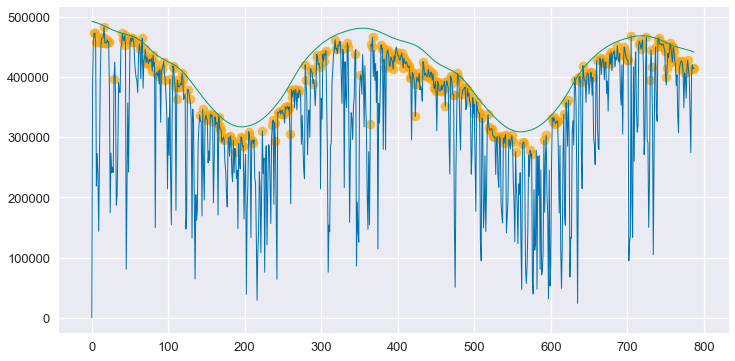

In [13]:
_ = ics.plot_energy()

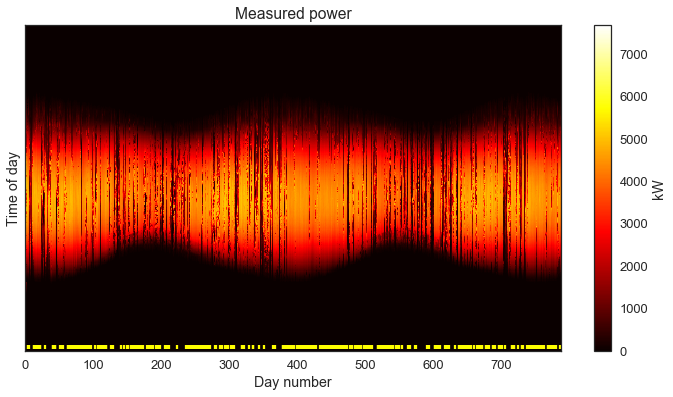

In [14]:
_ = ics.plot_D(show_days=True)

Here is the estimated degradation rate (year on year energy-yield) for the system:

In [15]:
ics.beta.value

array(-0.02615885)

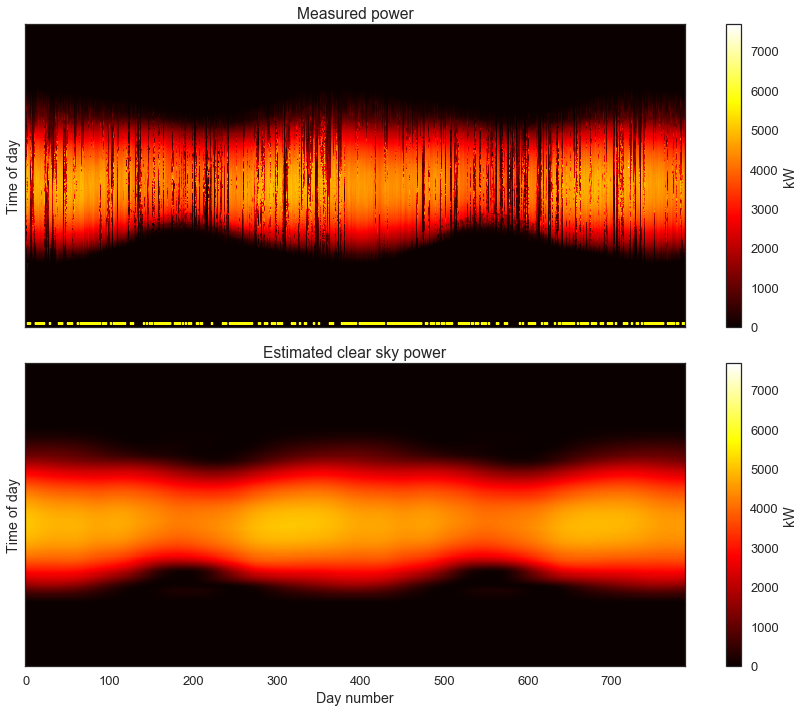

In [16]:
_ = ics.plot_measured_clear(figsize=(12, 10), show_days=True)

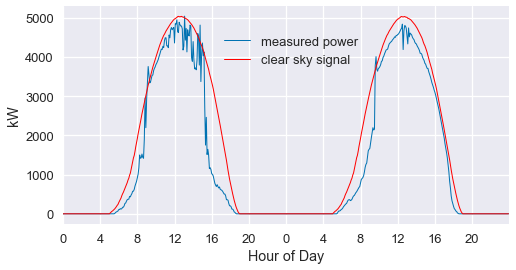

In [17]:
D1 = 350
D2 = D1 + 2
actual = p[D1*288:D2*288].values
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F')
fig, ax = plt.subplots(nrows=1, figsize=(8,4))
ax.plot(actual, linewidth=1, label='measured power')
ax.plot(clearsky, linewidth=1, color='red', label='clear sky signal')
plt.legend(loc=(.35,.7))
ax.set_xlim(0, 288*(D2-D1))
ax.set_ylabel('kW')
ax.set_xticks(np.arange(0, 288*2, 2*24))
ax.set_xticklabels(np.tile(np.arange(0,24,4),2))
ax.set_xlabel('Hour of Day')
plt.show()

In [18]:
print(sum(ics.L_cs.shape) + sum(ics.R_cs.shape))

1084


(0, 1440)

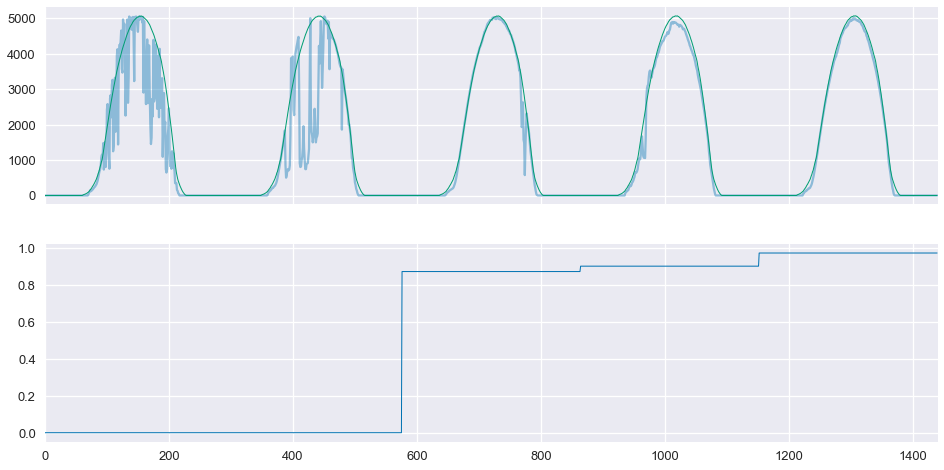

In [19]:
D1 = 300
D2 = D1+5
actual = p[D1*288:D2*288].values
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F')
fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[1].plot(np.repeat(ics.weights[D1:D2], 288), linewidth=1)
ax[1].set_xlim(0, 288*(D2-D1))

In [20]:
ics.beta.value

array(-0.02615885)

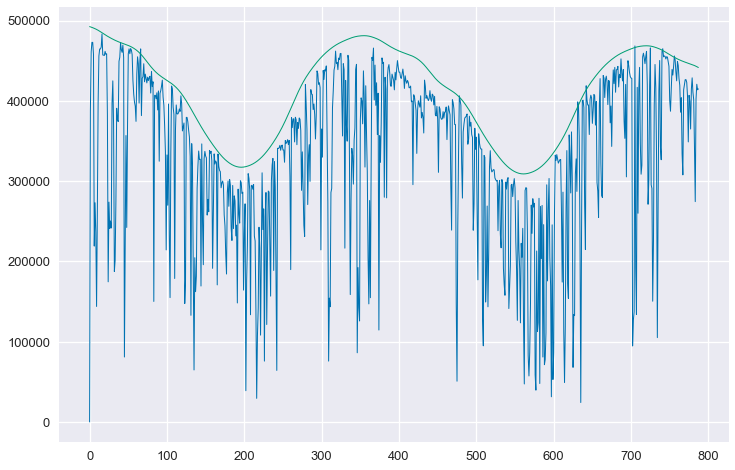

In [21]:
plt.figure(figsize=(12,8))
plt.plot(np.sum(D, axis=0), linewidth=1)
plt.plot(ics.R_cs.value[0] * np.sum(ics.L_cs.value[:, 0]), linewidth=1)

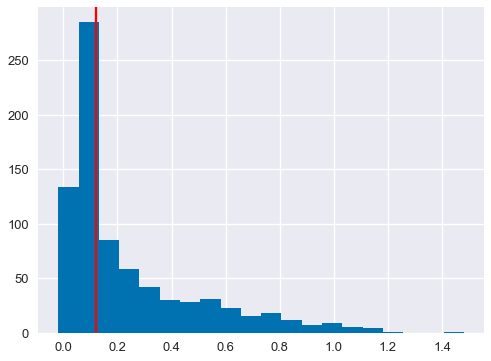

0.11962159739269071


In [22]:
residuals1 = (ics.R_cs.value[0] * np.sum(ics.L_cs.value[:, 0]) - np.sum(D, axis=0)) / np.average(np.sum(D, axis=0))
plt.figure(figsize=(8,6))
plt.hist(residuals1, bins=20)
plt.axvline(np.percentile(residuals1, 50), color='r')
plt.show()
print(np.percentile(residuals1, 50))

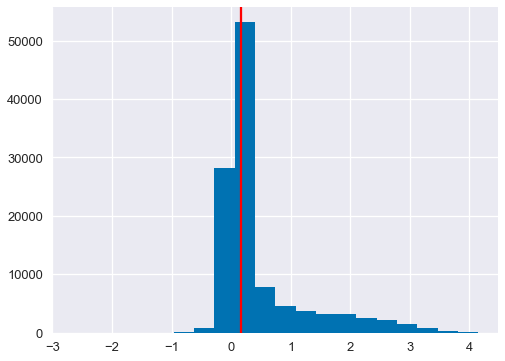

0.1607598463527716


In [23]:
residuals2 = ((ics.L_cs.value.dot(ics.R_cs.value) - ics.D) / np.average(ics.D))[ics.D > 1e-3]
plt.figure(figsize=(8,6))
plt.hist(residuals2, bins=20)
plt.axvline(np.percentile(residuals2, 50), color='r')
plt.show()
print(np.percentile(residuals2, 50))

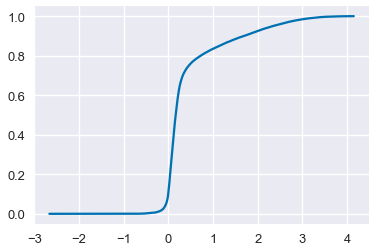

In [24]:
plt.plot(np.sort(residuals2), np.linspace(0, 1, len(residuals2), endpoint=False))

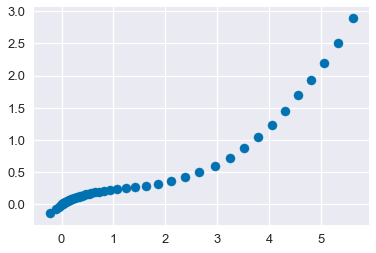

In [25]:
gq = np.load('good_quantiles.npy')
testq = np.percentile(residuals2, np.arange(2, 99, 2))
plt.scatter(gq, testq)

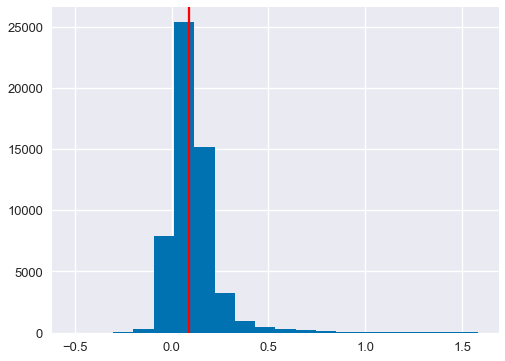

0.08925569877166423 0.12907363682715992


In [26]:
# Weight residuals by daily weight, which sets many days to zero. 
W1 = np.diag(ics.weights)
wres = np.dot(ics.L_cs.value.dot(ics.R_cs.value) - ics.D, W1)
use_days = np.logical_not(np.isclose(np.sum(wres, axis=0), 0))
scaled_wres = wres[:, use_days] / np.average(ics.D[:, use_days])
final_metric = scaled_wres[ics.D[:, use_days] > 1e-3]
plt.figure(figsize=(8,6))
plt.hist(final_metric, bins=20)
plt.axvline(np.percentile(final_metric, 50), color='r')
plt.show()
print(np.percentile(final_metric, 50), np.std(final_metric))

In [27]:
np.corrcoef(gq, testq)

array([[1.        , 0.94181448],
       [0.94181448, 1.        ]])

In [28]:
np.std(residuals2)

0.7596619589053093

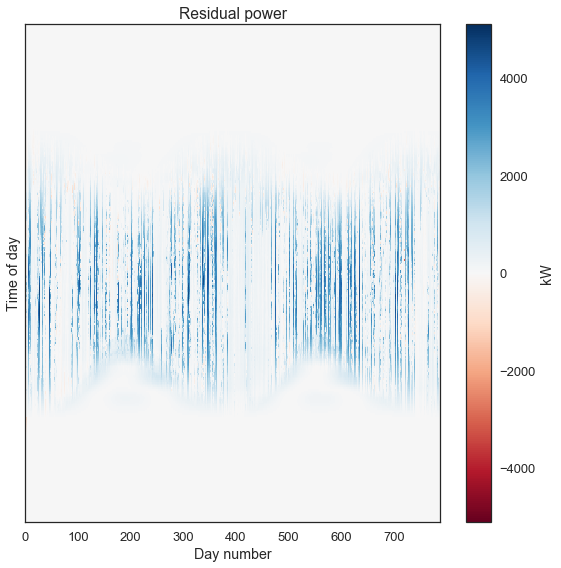

In [29]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(8,8), sharex=True)
    r = ics.L_cs.value.dot(ics.R_cs.value) - ics.D
    val = np.max([np.abs(np.min(r)), np.abs(np.max(r))])
    foo = ax.imshow(r, cmap='RdBu', interpolation='none', aspect='auto', vmin=-val, vmax=val)
    #plt.colorbar(label='kW')
    ax.set_title('Residual power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')
    plt.tight_layout()

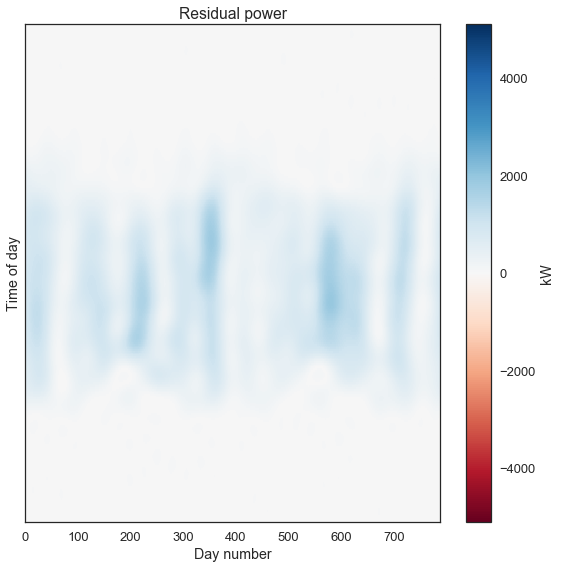

In [30]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(8,8), sharex=True)
    r = ics.L_cs.value.dot(ics.R_cs.value) - ics.D
    val = np.max([np.abs(np.min(r)), np.abs(np.max(r))])
    foo = ax.imshow(lowpass_2d(r, r=15), cmap='RdBu', interpolation='none', aspect='auto', vmin=-val, vmax=val)
    #plt.colorbar(label='kW')
    ax.set_title('Residual power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')
    plt.tight_layout()

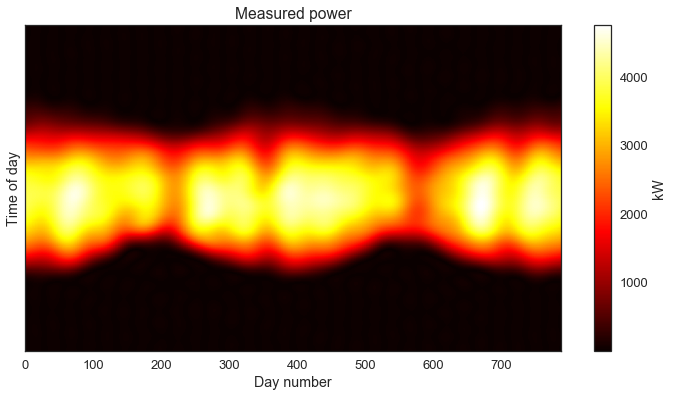

In [31]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
    foo = ax.imshow(lowpass_2d(D, r=15), cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax.set_title('Measured power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')

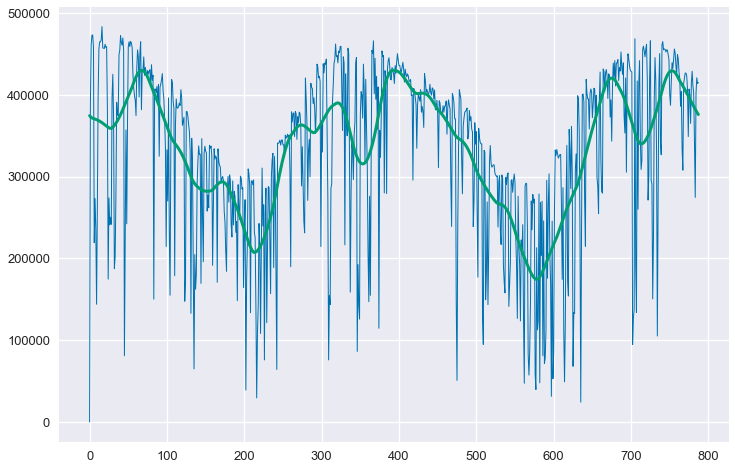

In [32]:
plt.figure(figsize=(12,8))
plt.plot(np.sum(D, axis=0), linewidth=1)
plt.plot(np.sum(lowpass_2d(D, r=15), axis=0), linewidth=3)